In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

In [2]:
file = r"...bike_sharing_daily.csv"
bikes = pd.read_csv(file,sep=',')
bikes['dteday'] = pd.to_datetime(bikes.dteday,format='%Y-%m-%d')
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


data \
https://www.kaggle.com/datasets/contactprad/bike-share-daily-data?resource=download

The below visualizations indicate that there could be outliers. I'll explore that possibility with a handful of methods.

The data's coding of seasons doesn't appear to make sense. Fall temps shouldn't be that much higher than summer. But I'll ignore that for the sake of this exercise and assume the data was generated and coded accurately.

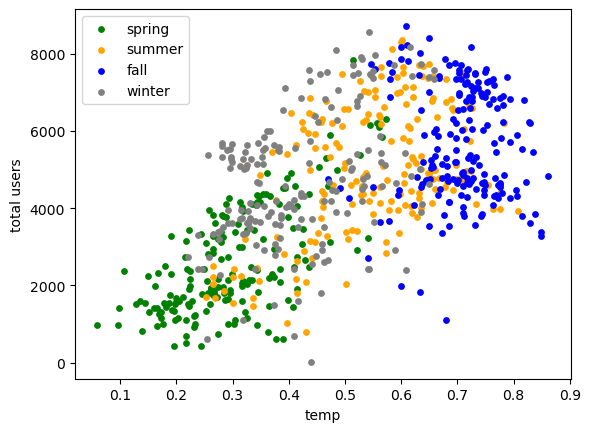

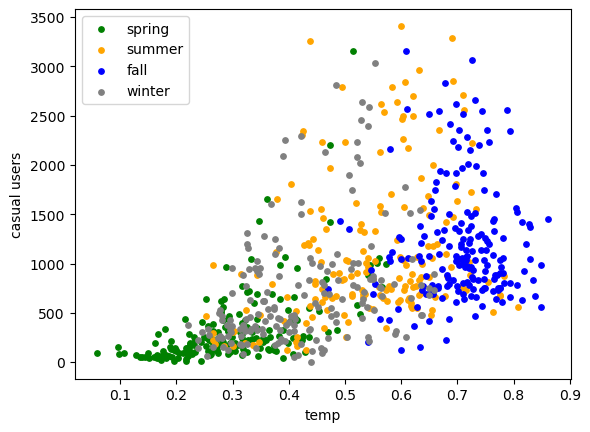

In [3]:
season_code = bikes.season.unique().tolist()
season_code.sort()
seasons = ['spring','summer','fall','winter']
cs = ['green','orange','blue','gray']
def usertemp(bikes):
    for sc, s, c in zip(season_code,seasons,cs):
        temp = bikes.loc[bikes.season==sc,'temp'].copy()
        tusers = bikes.loc[bikes.season==sc,'cnt'].copy()
        plt.scatter(temp,tusers,c=c,label=s,s=15)
    plt.xlabel('temp')
    plt.ylabel('total users')
    plt.legend()
    plt.show()

    for sc, s, c in zip(season_code,seasons,cs):
        temp = bikes.loc[bikes.season==sc,'temp'].copy()
        tusers = bikes.loc[bikes.season==sc,'casual'].copy()
        plt.scatter(temp,tusers,c=c,label=s,s=15)
    plt.xlabel('temp')
    plt.ylabel('casual users')
    plt.legend()
    plt.show()

usertemp(bikes)

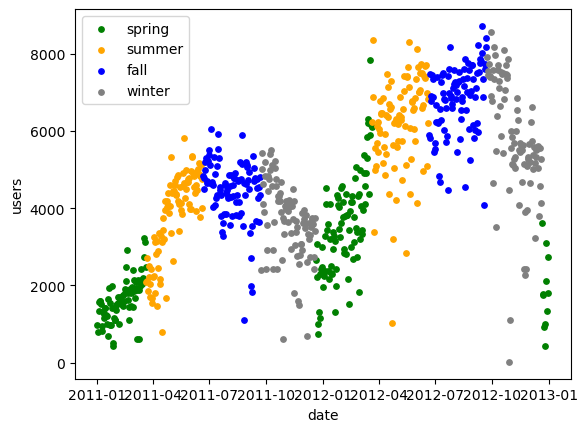

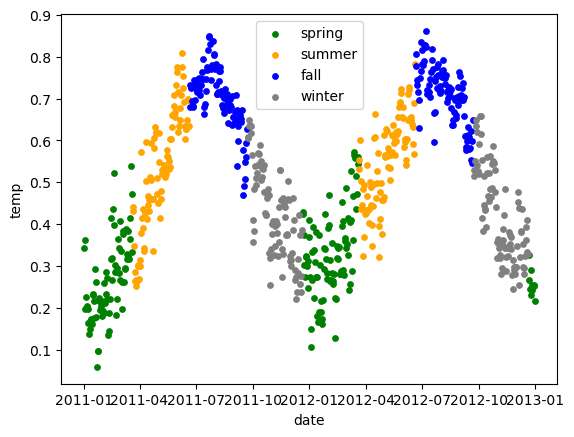

In [4]:
def usertempseries(bikes):
    for sc, s, c in zip(season_code,seasons,cs):
        day = bikes.loc[bikes.season==sc, 'dteday'].copy()
        cnt = bikes.loc[bikes.season==sc, 'cnt'].copy()
        plt.scatter(day,cnt,c=c,label=s,s=15)
    plt.legend()
    plt.xlabel('date')
    plt.ylabel('users')
    plt.show()

    for sc, s, c in zip(season_code,seasons,cs):
        day = bikes.loc[bikes.season==sc, 'dteday'].copy()
        temp = bikes.loc[bikes.season==sc, 'temp'].copy()
        plt.scatter(day,temp,c=c,label=s,s=15)
    plt.legend()
    plt.xlabel('date')
    plt.ylabel('temp')
    plt.show()

usertempseries(bikes)

### Outlier Detection

#### Isolation Forests
Choosing "contamination" gives the function as a parameter the percentage of expected outliers. I'll assume for the sake of exercise a reasonable proportion.

paper\
https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf \
https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf

In [5]:
quant_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']
bq = bikes[quant_vars]
all_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed','cnt'] # minus casual and registered
select_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'atemp', 'hum', 'windspeed']
ba = bikes[all_vars] # minus date

In [6]:
def z_scores(X):
    n = X.shape[0]
    X = X.to_numpy().reshape(n,-1)
    scaler = StandardScaler(with_mean=True,with_std=True)
    return scaler.fit_transform(X)

In [7]:
out_response = IsolationForest(contamination=0.1,
                              max_features=len(ba.columns)-2,
                              max_samples=250,
                              n_estimators=500).fit_predict(z_scores(ba))
orr = pd.Series(out_response).map({-1:1,1:0}).astype(bool)
ba['out_responses'] = orr
ba['day'] = bikes.index

This view is unenlightening. Rather than exploring which 2D views might best illustrate the outliers I'll use PCA to view 3 components in 3D.

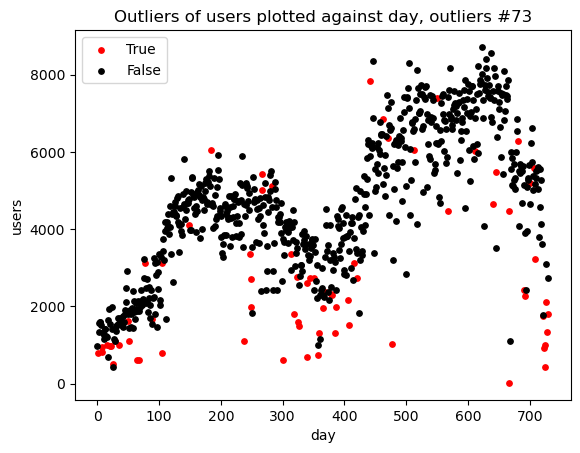

In [8]:
for o in [True,False]:
    c = 'red' if o else 'black'
    temp = ba.loc[ba.out_responses==o,'day'].copy()
    casuals = ba.loc[ba.out_responses==o,'cnt'].copy()
    plt.scatter(temp,casuals,c=c,label=o,s=15)
plt.xlabel('day')
plt.ylabel('users')
plt.title(f'Outliers of users plotted against day, outliers #{ba.out_responses.sum()}')
plt.legend(loc='upper left')
plt.show()

In [9]:
bqz = z_scores(ba)
bco = PCA(n_components=3).fit_transform(bqz)
bcodf = pd.DataFrame(bco).rename(columns={0:'pc1',1:'pc2',2:'pc3'})

out_response = IsolationForest(contamination=0.1,
                              max_features=len(ba.columns)-2,
                              max_samples=250,
                              n_estimators=500).fit_predict(z_scores(ba))
orr = pd.Series(out_response).map({-1:1,1:0}).astype(bool)
bcodf['out_responses'] = orr

This looks fantastic. There seem to be just a handful of false positives in there but this otherwise looks how I would expect.

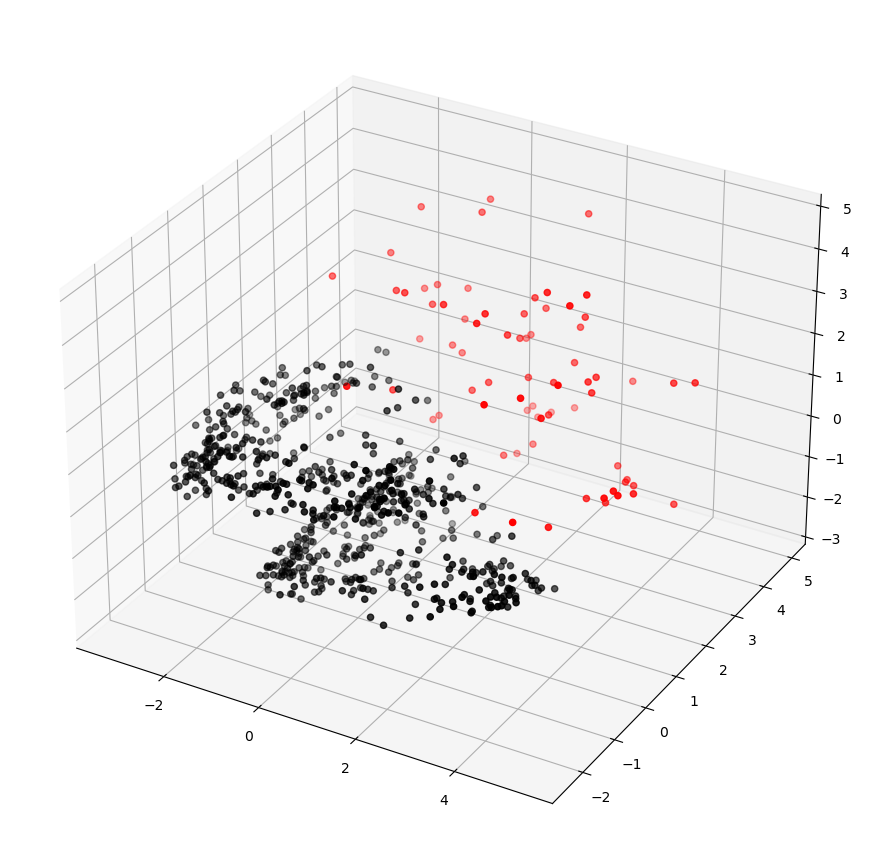

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(121,projection='3d')
fig.set_figheight(11)
fig.set_figwidth(11)
ax = plt.axes(projection='3d')

for o in [True,False]:
    co = 'Red' if o else 'Black'
    c_temp = bcodf.loc[bcodf.out_responses==o].copy()
    ax.scatter(c_temp.pc1,c_temp.pc2,c_temp.pc3,c=co)